## Importiing libs

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

## Building data

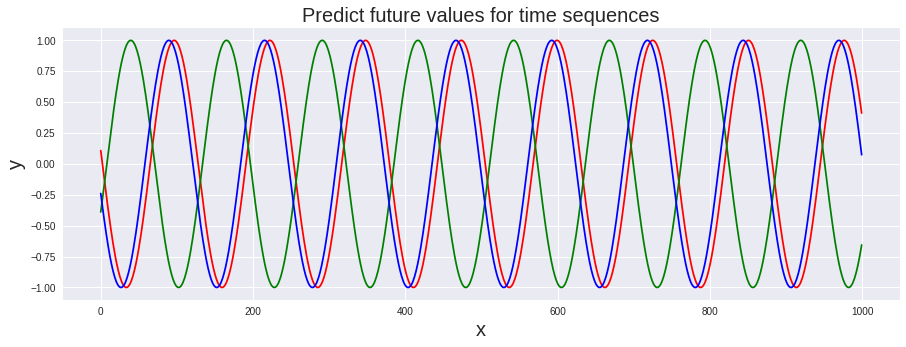

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')


plt.figure(figsize=(15,5))
plt.title('Predict future values for time sequences', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(data[0], 'r')
plt.plot(data[1], 'g')
plt.plot(data[2], 'b')

## Setting Architecture

* Implemente um modelo para predição de valores futuros de uma sequência usando apenas *LSTMCell*
* Cada entrada (caracter) possui dimensão (1): um ponto na série temporal
* *Hidden size* possui dimensão (128): hiperparâmetro 
* Saída possui dimensão (1): próximo ponto na série temporal
* Batch size = input_data.size(0) de acordo com a implementação do loop de treinamento

**Links úteis**

LSTMCell: https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Recurrent neural network 
class CustomNetwork(nn.Module):
    
    def __init__(self, cell_type="lstm", input_size=1, hidden_size=128, output_size=1, nonlinearity="tanh"):
        
        super(CustomNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.nonlinearity = nonlinearity.lower()
        assert self.nonlinearity in ['tanh', 'relu']

        self.cell_type = cell_type.lower()
        if self.cell_type == "lstm":
            self.layer1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
            self.layer2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.output_size)
        elif self.cell_type == "rnn":
            self.layer1 = nn.RNNCell(input_size=self.input_size, hidden_size=self.hidden_size, nonlinearity=self.nonlinearity)
            self.layer2 = nn.RNNCell(input_size=self.hidden_size, hidden_size=self.output_size, nonlinearity=self.nonlinearity)
        elif self.cell_type == "gru":
            self.layer1 = nn.GRUCell(input_size=self.input_size, hidden_size=self.hidden_size)
            self.layer2 = nn.GRUCell(input_size=self.hidden_size, hidden_size=self.output_size)
        else:
            raise ("Please enter a good cell type (LSTM/RNN/GRU)")

       

    def forward(self, input_data, future=0):

        # Set initial hidden and cell states 
        h_t = Variable(torch.zeros(input_data.size(0), self.hidden_size).double(), requires_grad=False).cuda()
        h_t2 = Variable(torch.zeros(input_data.size(0), self.output_size).double(), requires_grad=False).cuda()

        if self.cell_type == "lstm":
            c_t = Variable(torch.zeros(input_data.size(0), self.hidden_size).double(), requires_grad=False).cuda()
            c_t2 = Variable(torch.zeros(input_data.size(0), self.output_size).double(), requires_grad=False).cuda()

        # Loop to feed the network one time step at a time
        outputs = []
        for i, input_t in enumerate(input_data.chunk(input_data.size(1), dim=1)):
            if self.cell_type == "lstm":
                h_t, c_t = self.layer1(input_t, (h_t, c_t))
                h_t2, c_t2 = self.layer2(c_t, (h_t2, c_t2))
                outputs += [c_t2]
            else:
                h_t = self.layer1(input_t, h_t)
                h_t2 = self.layer2(h_t, h_t2)
                outputs += [h_t2]

        # If predicting the future (test time)
        for i in range(future):  
            if self.cell_type == "lstm":
                h_t, c_t = self.layer1(c_t2, (h_t, c_t))
                h_t2, c_t2 = self.layer2(c_t, (h_t2, c_t2))
                outputs += [c_t2]
            else:
                h_t = self.layer1(h_t2, h_t)
                h_t2 = self.layer2(h_t, h_t2)
                outputs += [h_t2]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

# Build the model
#seq = CustomNetwork(cell_type='lstm').double()
seq = CustomNetwork(cell_type='lstm').double().cuda() #GPU

## Setting Loss and Optimizer

In [0]:
import torch.optim as optim

#criterion = nn.MSELoss()
criterion = nn.MSELoss().cuda() #GPU

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

## Train / Test Model

Epoch [1/7], Loss: 0.002527
Epoch [2/7], Loss: 0.000103
Epoch [3/7], Loss: 0.000067
Epoch [4/7], Loss: 0.000085
Epoch [5/7], Loss: 0.000068
Epoch [6/7], Loss: 0.000050
Epoch [7/7], Loss: 0.000041


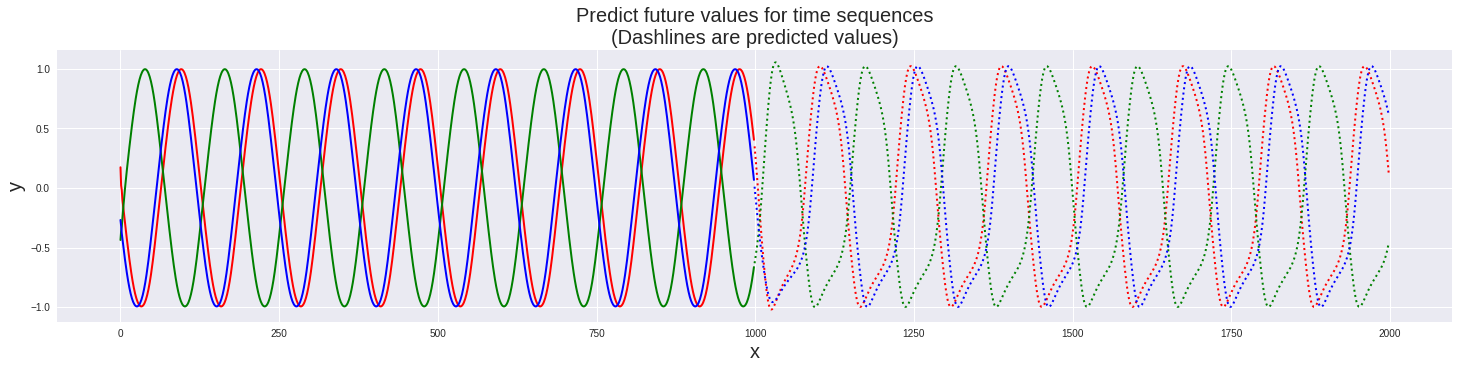

In [8]:
#input = Variable(torch.from_numpy(data[3:, :-1]).double())
#target = Variable(torch.from_numpy(data[3:, 1:]).double())
#test_input = Variable(torch.from_numpy(data[:3, :-1]).double())
#test_target = Variable(torch.from_numpy(data[:3, 1:]).double())

#GPU
input = Variable(torch.from_numpy(data[3:, :-1]).double()).cuda() 
target = Variable(torch.from_numpy(data[3:, 1:]).double()).cuda()
test_input = Variable(torch.from_numpy(data[:3, :-1]).double()).cuda()
test_target = Variable(torch.from_numpy(data[:3, 1:]).double()).cuda()

# Train the model
num_epochs=7
for epoch in range(num_epochs):
  
    # Set to Train mode
    seq.train()
    
    # Forward and Backward pass
    def closure():
      optimizer.zero_grad()
      out = seq(input)
      loss = criterion(out, target)
      loss.backward()
      return loss
    optimizer.step(closure)
    
    # Test the model
    
    # Set to eval mode
    seq.eval()
    
    future = 1000
    pred = seq(test_input, future=future)
    loss = criterion(pred[:, :-future], test_target)
    print ('Epoch [{}/{}], Loss: {:.6f}' 
                   .format(epoch+1, num_epochs, loss.data[0]))

# Draw the result
y = pred.data.cpu().numpy()
plt.figure(figsize=(25,5))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
    